In [83]:
""" Camila Losada 2024/10/23 """

' Camila Losada 2024/10/23 '

In [84]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath("/home/closada/cami/code/nest_project_eitn_24/utils/inputs.py"))
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [85]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import nest
import itertools
from utils.inputs import generate_piecewise_constant_signal
from utils.capacity import compute_capacity
from utils.extractors import filter_spikes_parallel
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
from scipy import sparse

In [86]:
seed = 1
np.random.seed(seed)

In [87]:
def get_sparse_matrix(rows,cols,probability,seed):
    # Set the random seed for reproducibility
    rng = np.random.default_rng(seed)
    # Generate a random sparse matrix with values 0 or 1
    sparse_matrix = sparse.random(rows, cols, density=probability, format='csr', random_state=rng, data_rvs=lambda s: rng.integers(1, 2, size=s))
    # Convert the sparse matrix to a dense format
    dense_matrix = sparse_matrix.toarray()
    return dense_matrix


In [88]:
def get_sorted_spikes(args):
    recorder, idx = args
    return list(np.sort(nest.GetStatus(recorder)[idx]['events']['times']))

In [89]:
class BrunelNetwork:
    def __init__(self, g, eta,w, w_e,w_i, neuron_params, NE, NI,CE,CI,NrE, NrI, rec_start, rec_stop,input_s):
        self.num_ex = NE  # number of excitatory neurons
        self.num_in = NI  # number of inhibitory neurons
        self.c_ex = CE  # number of excitatory connections
        self.c_in = CI  # number of inhibitory connections
        self.w_e = w_e  # excitatory weight
        self.w_i = w_i  # inhibitory weight
        self.w = w
        self.n_rec_ex = NrE # number of recorded excitatory neurons, both excitatory and inhibitory
        self.n_rec_in = NrI # number of recorded in neurons, both excitatory and inhibitory
        self.rec_start = rec_start
        self.rec_stop = rec_stop
        self.neuron_params = neuron_params  # neuron params
        self.input_s=input_s
        self.ext_rate = (self.neuron_params['V_th'] 
                         / (self.w * self.c_ex * self.neuron_params['tau_m'])
                         * eta * 1000. * self.c_ex)
 
    def create_network(self):
        # Create the network
        
        # First create the neurons
        self.neurons_ex = nest.Create('iaf_psc_delta', self.num_ex, params=self.neuron_params)
        self.neurons_in = nest.Create('iaf_psc_delta', self.num_in, params=self.neuron_params)
        
        self.neurons = self.neurons_ex + self.neurons_in
        # #Then create spike detectors
        self.recorder_ex = nest.Create('spike_recorder',
                                       #self.n_rec_ex,
                                       params={'start' : self.rec_start, 'stop': self.rec_stop})
        self.recorder_in = nest.Create('spike_recorder',
                                       #self.n_rec_in,
                                       params={'start': self.rec_start, 'stop': self.rec_stop})

        # Next we connect the neurons
        # Iterate by row in w
        for i_row in range(self.num_ex):
            # select non-zero weights
            nonzero = self.w_e != 0
            nonzero_row = nonzero[i_row]
            nest.Connect(self.neurons_ex[i_row], self.neurons_ex[nonzero_row],
                        conn_spec = {'rule': 'all_to_all'},
                        syn_spec = {'synapse_model': 'static_synapse',
                                    'delay': 1.5,
                                    'weight': self.w_e[i_row][nonzero_row].reshape((-1,1))})      
        nest.Connect(self.neurons_ex, self.neurons_in,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_ex},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w})
        nest.Connect(self.neurons_in, self.neurons,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_in},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w_i}) 
                           
                                 
        # Then we connect the the neurons to the spike recorders
        nest.Connect(self.neurons_ex, self.recorder_ex)
        nest.Connect(self.neurons_in, self.recorder_in)
        
        # Add voltimeter for the decoder
        self.vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': 1})
        nest.Connect(self.vm, self.neurons_ex)

    def generate_input(self,sim_time):
        input_dt = 0.1           
        step_duration = 20.    
        scale = self.ext_rate  # input scaling factor [Hz]
        num_steps = int( sim_time/  step_duration )     # number of unique input values
        
        
        # Then create the external spike generator
        self.poisson_noise = nest.Create('poisson_generator', params={'rate': self.ext_rate})
        # create inhomogeneous poisson generator (time-dependent input signal)
        if self.input_s == 'signal':
            self.stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
            # # external input (stimulus)
            self.sig, self.times, self.inp_times, self.inp_amplitudes = generate_piecewise_constant_signal(seed=seed, num_steps=num_steps, 
                                                                                    step_duration=step_duration, 
                                                                                    resolution=input_dt, scale=scale)
            
            self.stim_pgen.set({'rate_times': self.inp_times, 'rate_values': self.inp_amplitudes})
            nest.Connect(self.stim_pgen, self.neurons,
                        syn_spec = {'synapse_model': 'static_synapse',
                                    'delay': 1.5,
                                    'weight': self.w})
            
        # Then we connect the external drive to the neurons
        nest.Connect(self.poisson_noise, self.neurons,
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.w})


    def simulate(self, t_sim):
        # Simulate the network with specified 
        nest.Simulate(t_sim)
        # to acquire the last time step in the multimeter
        #nest.Simulate(1)
    
    def get_data(self):
        # get spikes from recorders
        spikes_ex = []
        spikes_in = []
        
        for i in range(self.n_rec_ex):
            spikes_ex.append(
                list(np.sort(nest.GetStatus(self.recorder_ex)[i]['events']['times'])))
        for i in range(self.n_rec_in):
            spikes_in.append(
                list(np.sort(nest.GetStatus(self.recorder_in)[i]['events']['times'])))
            
        return spikes_ex, spikes_in
    def plot(self):
        nest.raster_plot.from_device(self.recorder_ex, hist=True)
        nest.raster_plot.from_device(self.recorder_in, hist=True)

In [90]:
# Helper function to plot spiking activity
def plot_raster_rate(spikes_ex, spikes_in, rec_start, rec_stop, figsize=(9, 5),save=False,path='./'):
    
    spikes_ex_total = list(itertools.chain(*spikes_ex))
    spikes_in_total = list(itertools.chain(*spikes_in))
    spikes_total = spikes_ex_total + spikes_in_total
    
    n_rec_ex = len(spikes_ex)
    n_rec_in = len(spikes_in)
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(5, 1)
    
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4,0])
    
    ax1.set_xlim([rec_start, rec_stop])
    ax2.set_xlim([rec_start, rec_stop])
    
    ax1.set_ylabel('Neuron ID')
    
    ax2.set_ylabel('Firing rate')
    ax2.set_xlabel('Time [ms]')
    
    
    for i in range(n_rec_in):
        ax1.plot(spikes_in[i],
                 i*np.ones(len(spikes_in[i])),
                 linestyle='',
                 marker='o',
                 color='r',
                 markersize=2)
    for i in range(n_rec_ex):
        ax1.plot(spikes_ex[i],
                 (i + n_rec_in)*np.ones(len(spikes_ex[i])),
                 linestyle='',
                 marker='o',
                 color='b',
                 markersize=2)

        
    ax2 = ax2.hist(spikes_ex_total,
                   range=(rec_start,rec_stop),
                   bins=int(rec_stop - rec_start))
    if save:
        plt.savefig(path+'raster.png')

    time_diff = (rec_stop - rec_start)/1000.
    average_firing_rate = (len(spikes_total)
                           / time_diff
                           /(n_rec_ex + n_rec_in))
    print(f'Average firing rate: {average_firing_rate} Bq')
    

In [91]:
1000/80

12.5

In [92]:
# network parameters-----------
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
c_factor=2
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)  
Ntotal=NE+NI

# synapse parameters----------
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)
# Define W matrix
w = 0.1 # excitatory synaptic weight (mV)
w *= np.sqrt(10)
n_clusters = 12
# wc = [w *i for i in range(1,(n_clusters+1)*2,2)]
w_factor = 7 # scaling clusters w
wc = [w*w_factor]*n_clusters
w_ex = np.full((NE,NE),w,dtype=np.float64)
nn_c = int(NE/n_clusters)# number of units per cluster
for i_n in range(n_clusters):
    st=i_n*nn_c
    end=(i_n+1)*nn_c
    w_ex[st:end,st:end] = wc[i_n]
w_i = -w*g
w_sparse = get_sparse_matrix(rows=w_ex.shape[0],cols=w_ex.shape[1],probability=0.1,seed=seed)
w_sparse = w_ex*w_sparse

# neuron paramters----------------
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}
params = {'g':g, 
          'eta':1.5,#set external rate above threshold, 
          'w':w,
          'w_e':w_sparse,
          'w_i':w_i,
          'neuron_params':neuron_params,    
          'NE':NE,
          'NI':NI,
          'CE':int(c_factor*CE),
          'CI':int(c_factor*CI), 
          'NrE':NE, 
          'NrI':NI, 
          'rec_start':0, 
          'rec_stop':2100,
          'input_s':'signal'
}

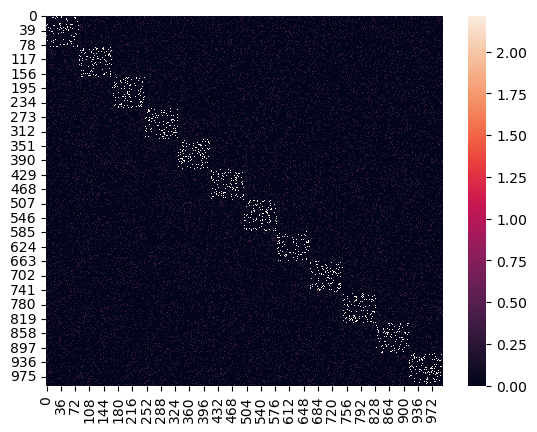

In [93]:
res_name = f"results/{params['input_s']}/w{params['w']}_eta{params['eta']}_w_i{params['w_i']}_nc{n_clusters}_wf{w_factor}_g{params['g']}_cf{c_factor}"
ff=sns.heatmap(w_sparse)
figure = ff.get_figure()    
figure.savefig(f'{res_name}.png', dpi=400)

In [95]:
dt = 0.1  # simulation resolution
num_threads = 4
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})
sim_time = 2100. # simulation time [ms] (for each epoch)
network = BrunelNetwork(**params)
network.create_network()
network.generate_input(sim_time)
network.simulate(sim_time)

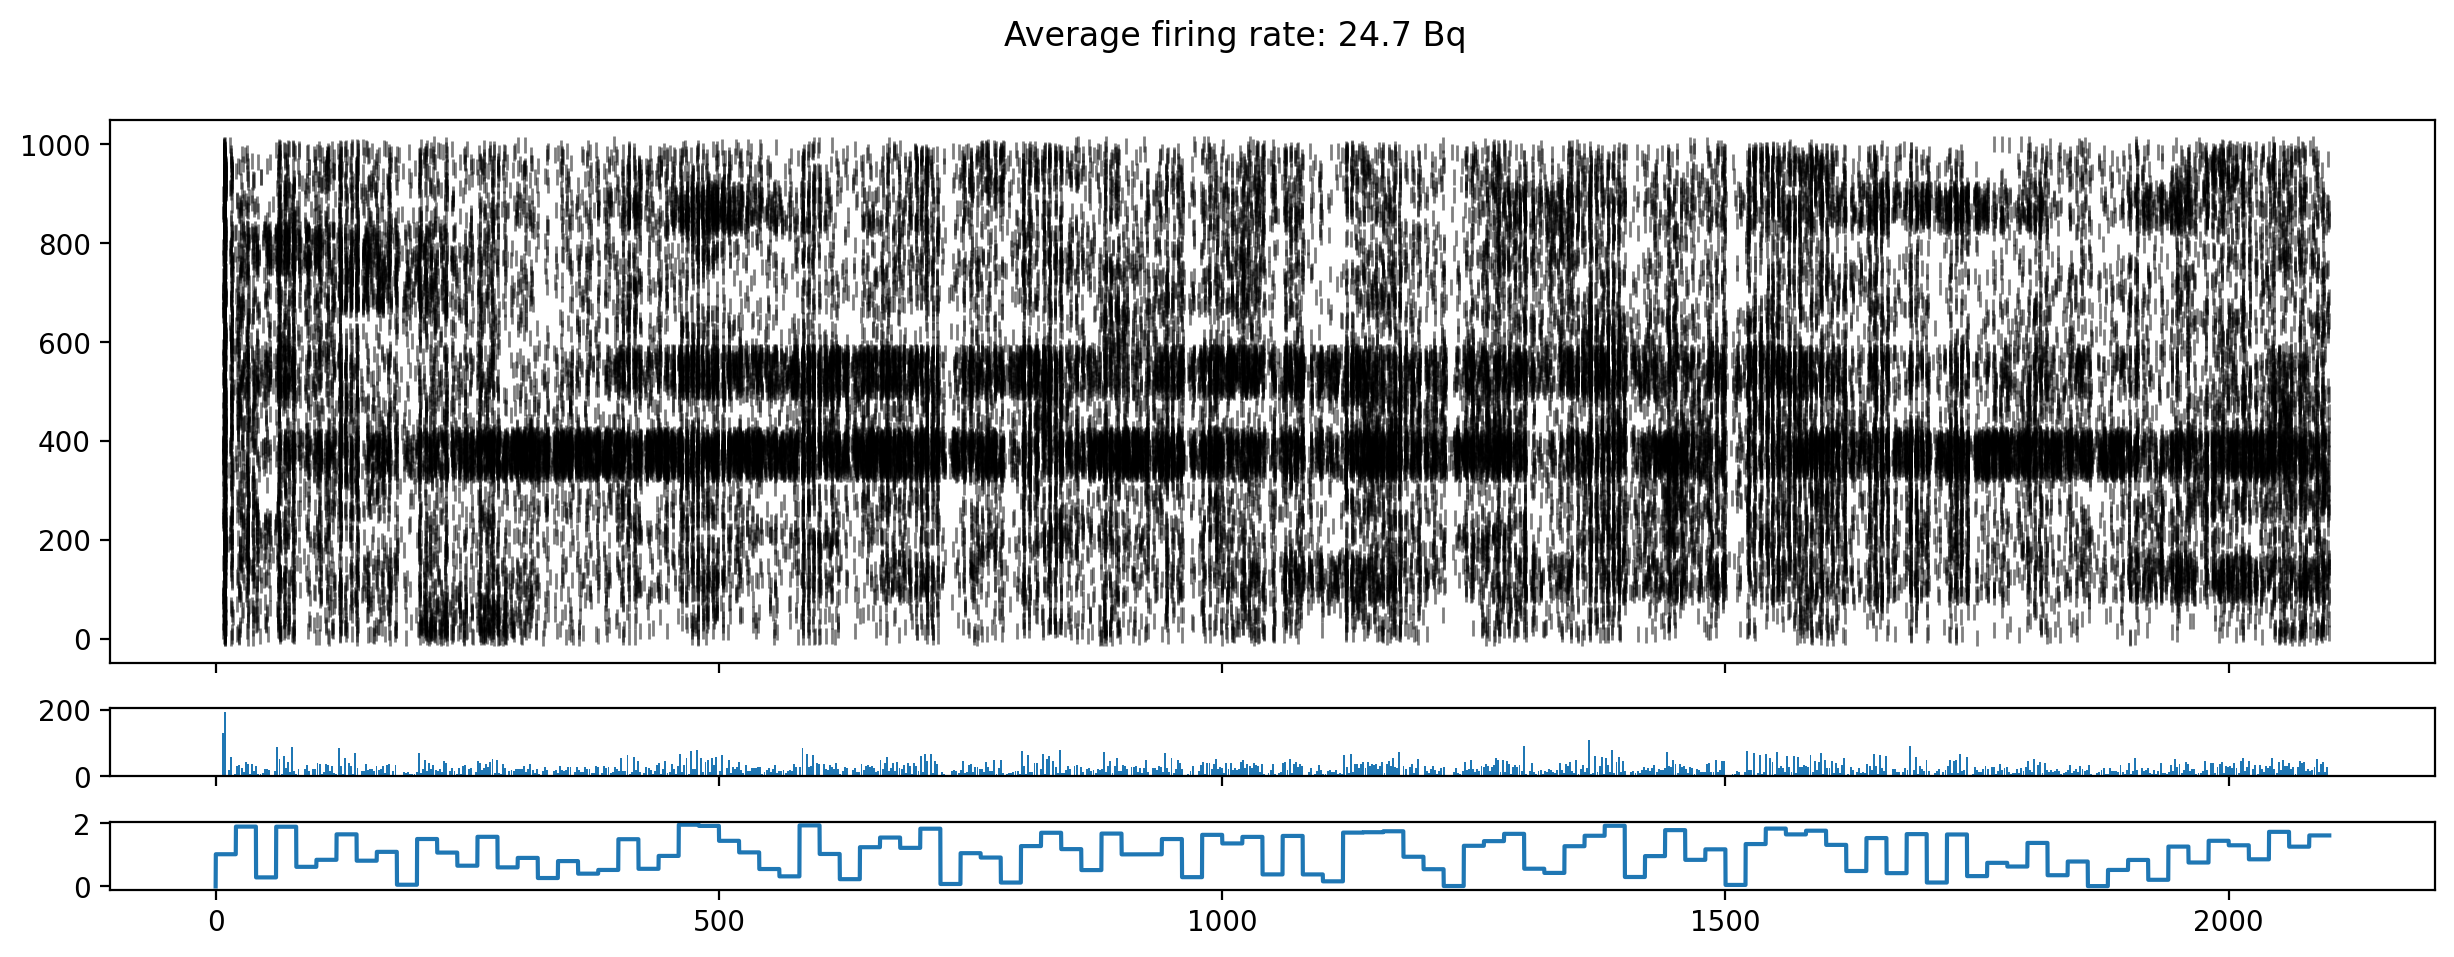

In [96]:
# graphical representation of the main network
ncols=1
gridspec_kw = {"height_ratios":[0.9,0.1]}
if params['input_s']=='signal':
    nrows=3
    gridspec_kw = {"height_ratios":[0.8,0.1,0.1]}
fig,ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(15,5),
    dpi=200,
    gridspec_kw=gridspec_kw,
    sharex=True
)
spikes_ex = network.recorder_ex.events["times"]
sp_senders_ex = network.recorder_ex.events["senders"]
ax[0].plot(
    spikes_ex,
    sp_senders_ex,
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    spikes_ex,
    bins=np.linspace(spikes_ex.min(), spikes_ex.max(), 1_000)
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)
if params['input_s']=='signal':
    ax[2].plot(
        network.times,
        network.sig
    )
time_diff = (params['rec_stop']-params['rec_start'])/1000.
average_firing_rate = (len(spikes_ex)
                        / time_diff
                        /params['NrE'])
fig.suptitle(f'Average firing rate: {np.round(average_firing_rate,2)} Bq')
fig.savefig(res_name+'raster.png')

In [97]:
network.times.shape

(21001,)

In [98]:
network.sig.shape

(21001,)

In [99]:
params['rec_stop']

2100

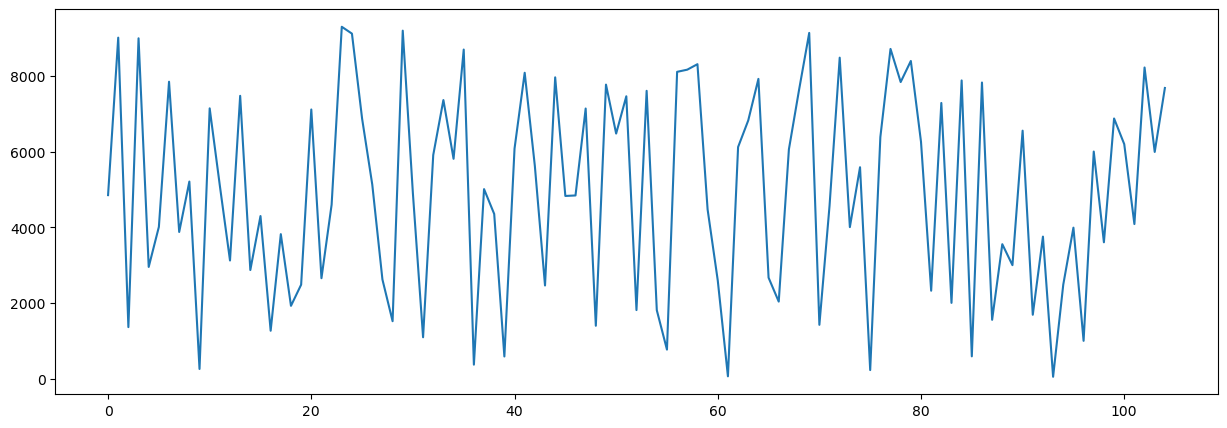

In [100]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(
    #network.times,
    network.inp_amplitudes
)

In [101]:
def extract_results(
    spks,
    filter_tau,
    sim_time,
    NE,
    dt,
    num_threads=1

):
    
    activity = spks.events
    states = filter_spikes_parallel(
        activity['times'], activity['senders'], 
        NE, 
        t_start=0., t_stop=sim_time, dt=dt, 
        tau=filter_tau, 
        n_processes=num_threads
    )

    return activity, states

In [102]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(
        n_jobs=-1, 
        fit_intercept=False
    ).fit(x.T, z)
    
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [103]:
filter_tau = 20. # [ms]
activity, states = extract_results(
    spks=network.recorder_ex,
    filter_tau=filter_tau,
    sim_time=sim_time,
    NE=NE,
    dt=0.1, 
    num_threads=8)

Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:05<00:00, 15.29it/s]


In [104]:
sim_time

2100.0

In [105]:
states.shape

(1000, 21000)

In [106]:
network.sig.shape

(21001,)

In [107]:
estimate, capacity, error = compute_capacity(states, network.sig[1:])
print(f"Network: \n\t- Capacity={capacity}, MSE={error}")

Network: 
	- Capacity=0.9113010215924917, MSE=0.02880131887672137


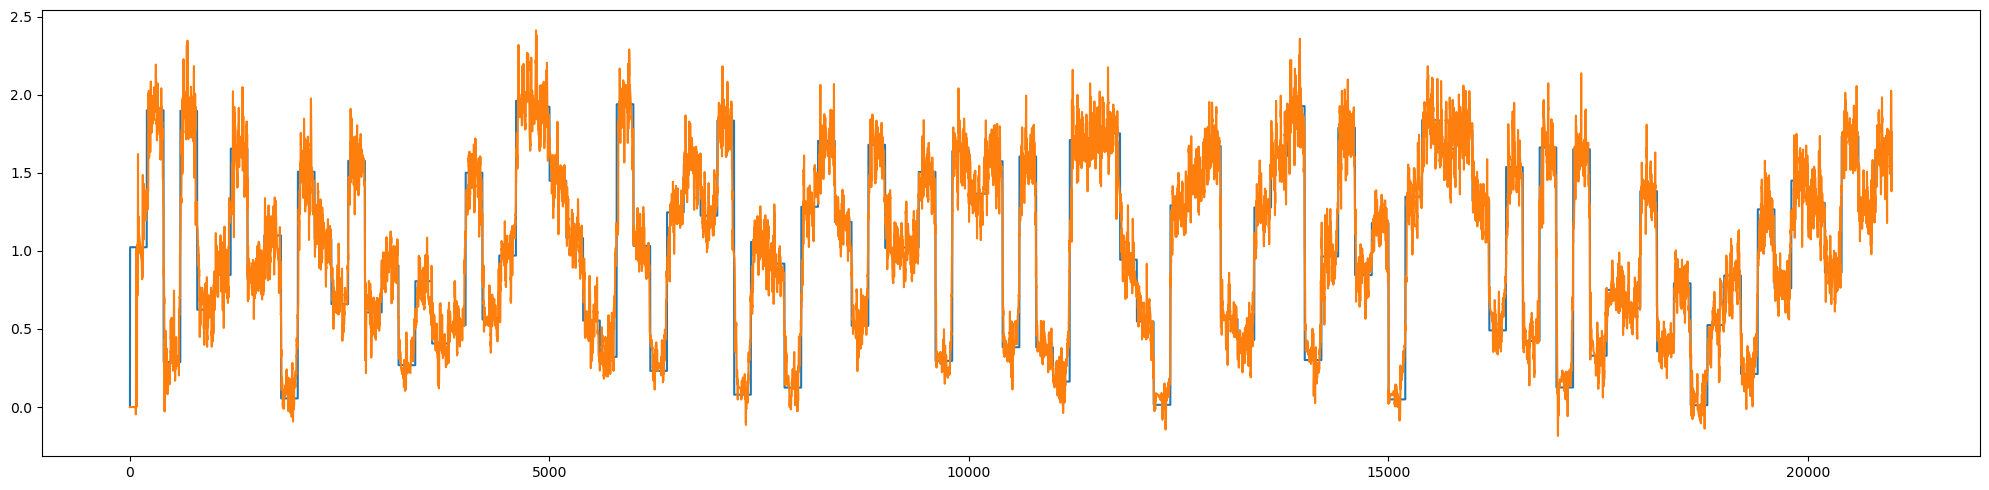

In [108]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,5)
)

ax.plot(
    network.sig
)

ax.plot(
    estimate   
)


plt.tight_layout()
plt.show()

In [109]:
# connections = nest.GetConnections(source=network.neurons_ex, target=network.neurons_ex)
# C = np.zeros((len(network.neurons_ex) + 1, len(network.neurons_ex) + 1))
# for c in connections:
#     C[c.source][c.target] = c.weight


In [110]:
# f,ax=plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
# #sns.heatmap(C[1:,1:],ax=ax[0])
# #sns.heatmap(w_sparse,ax=ax[1])
# diff = C[1:,1:]-w_sparse
# #sns.heatmap(diff,ax=ax[2])
# print(np.unique(C))